In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from IPython.display import clear_output, Image, display, HTML

###### Do not modify here ###### 
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = graph_def
    #strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
###### Do not modify  here ######

###### Implement Data Preprocess here ######
housing = fetch_california_housing()
# Show description/ statisics about the dataset
print(housing.DESCR)

California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.




## Data Pre-processing

In [2]:
# Define cut point
cut = int(housing.data.shape[0]*0.9)
# Convert to column vector format, which is (n,1) not (n,)
housing.target = housing.target.reshape(housing.target.shape[0],1)
# Split dataset
x_train, x_test = housing.data[:cut], housing.data[cut:]
y_train, y_test = housing.target[:cut], housing.target[cut:]

print("\nShape of training set:", x_train.shape)
print("Shape of testing set:", x_test.shape)
print("Shape of training label:", y_train.shape)
print("Shape of testing label:", y_test.shape)


Shape of training set: (18576, 8)
Shape of testing set: (2064, 8)
Shape of training label: (18576, 1)
Shape of testing label: (2064, 1)


## Standardization & Include Bias to Weight Matrix

(Useless in this case, it's linear transformation which can be solve in coeifficient calculation step)

In [3]:
# x_train_ = np.concatenate((x_train,np.ones([x_train.shape[0],1])),axis=1)
# x_test_  = np.concatenate((x_test ,np.ones([ x_test.shape[0],1])),axis=1)
x_train_ = np.concatenate((np.divide(x_train - np.mean(x_train, axis=0, keepdims=True), np.std(x_train, axis=0, keepdims=True)),np.ones([x_train.shape[0],1])),axis=1)
x_test_  = np.concatenate((np.divide(x_test  - np.mean(x_train, axis=0, keepdims=True), np.std(x_train, axis=0, keepdims=True)),np.ones([ x_test.shape[0],1])),axis=1)

## Define Graph

In [4]:
# Clear graph
tf.reset_default_graph()

# Define variables to take input feature x, label y
x = tf.placeholder(tf.float32, shape = [None, x_train_.shape[1]], name="Input")
y = tf.placeholder(tf.float32, shape = [None, 1], name="Y")
W = tf.placeholder(tf.float32, shape = [x_train_.shape[1], 1], name="W")

# Calculate W
XT = tf.matrix_transpose(x, name="X_Transpose") # calculate transpose x
W_train = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, x, name="XT_X") , name="Inverse_XT_X"),XT, name="Multiple_XT"),y, name="Multiple_y") # calculate w by formula

# Systems of linear equation
linear_regression = tf.matmul(x, W, name="Linear_Regression")

# Calculate the mean of error rate
mean_error_rate = tf.reduce_mean(tf.divide(tf.abs(tf.subtract(y,linear_regression, name="Predict_Difference")),y,name="Error_Rate"), name="Mean_Error_Rate")


### Graph Explain and Result

To get the weight $W$ for linear equation 

$\hat y = XW + b$

We can utilizing following equation to solve it

$W=(X^{(train)\top} X^{(train)})^{-1} X^{(train)\top} y^{(train)}$

1. We set the placeholder to take the input feature as variable x and label as variable y, which corresponding to **Input** and **Y** in the graph below. Note that the x is original feature concatenate with 1 which represented the Bias $b$.

2. To calculate the Weight $W$,

    a. We calculate the element transpose X as variable XT which is **Inverse_XT_X** in graph.
    
    b. Calculate though the equation $W=(X^{(train)\top} X^{(train)})^{-1} X^{(train)\top} y^{(train)}$ to get W.
    
    c. By this step, we already get W for this systems of linear equation. Therefore, we are able to calculate the predict y via $XW$ as **Linear_Regression** in the graph.
    
    d. Finally, we calculte the mean error rate via $ \frac{1}{m} \sum \frac{\lvert(y -\hat y) \rvert}{y}$. which is the right-top part in the graph. Calculate the **Predict_Difference** via $y - \hat y$, take absolute value (**Abs**), calculate **Error_Rate** ($y$ as denominator), then take the mean of error rate (**Mean_Error_Rate**).

## Before Pre-processing

In [5]:
init_w = np.ones((9,1),dtype=np.float64)
with tf.Session() as sess:
    ###### Start TF session ######
    W_t = sess.run(W_train, {x: x_train_, y: y_train, W:init_w}) # Calculate W
#     print(W_t)
    print("Training Error Rate: ", sess.run(mean_error_rate, {x: x_train_, y: y_train, W:W_t}))
    print(" Testing Error Rate: ", sess.run(mean_error_rate, {x: x_test_, y: y_test, W:W_t}))
    
    show_graph(tf.get_default_graph().as_graph_def())

Training Error Rate:  0.31686
 Testing Error Rate:  0.344205


## Non-linear scaler

In [6]:
from sklearn import linear_model
from sklearn import preprocessing

In [7]:
quantileTransformer = preprocessing.QuantileTransformer(n_quantiles=2)
x_train__ = quantileTransformer.fit_transform(x_train)
x_test__ = quantileTransformer.transform(x_test)

print("Linear Regression")

# Create linear regression object
regr = linear_model.LinearRegression()
regr.fit(x_train__,y_train)

# Make predictions using the testing set
y_pred = regr.predict(x_test__)

# The coefficients
# print('Coefficients: \n', regr.coef_)
print('Train Error rate: ', np.mean(np.absolute(y_train - regr.predict(x_train__))/y_train))
print('Test  Error rate: ', np.mean(np.absolute(y_test - y_pred)/y_test))

print("\nTensorflow")

# Include Bias to weight matrix
x_train__ = np.concatenate((x_train__,np.ones([x_train.shape[0],1])),axis=1)
x_test__  = np.concatenate((x_test__,np.ones([ x_test.shape[0],1])),axis=1)

with tf.Session() as sess:
    W_t = sess.run(W_train, {x: x_train__, y: y_train, W:init_w}) # Calculate W
    
    print("Train Error Rate: ", sess.run(mean_error_rate, {x: x_train__, y: y_train, W:W_t}))
    print("Test  Error Rate: ", sess.run(mean_error_rate, {x: x_test__, y: y_test, W:W_t}))

Linear Regression
Train Error rate:  0.316859907326
Test  Error rate:  0.343152052243

Tensorflow
Train Error Rate:  0.316858
Test  Error Rate:  0.343149


## Polynominal feature

Doesn't need to adding the bias, cause polynominal feature is already include it.

In [8]:
from sklearn.preprocessing import PolynomialFeatures

In [9]:
poly = PolynomialFeatures(2)
x_train__ = poly.fit_transform(x_train_[:,:8])
x_test__ = poly.transform(x_test_[:,:8])
print(x_train__.shape)

print("Linear Regression")
# Create linear regression object
regr = linear_model.LinearRegression()
regr.fit(x_train__,y_train)

# Make predictions using the testing set
y_pred = regr.predict(x_test__)

# The coefficients
# print('Coefficients: \n', regr.coef_)
print('Train Error rate: ', np.mean(np.absolute(y_train - regr.predict(x_train__))/y_train))
print('Test  Error rate: ', np.mean(np.absolute(y_test - y_pred)/y_test))


(18576, 45)
Linear Regression
Train Error rate:  0.263892043838
Test  Error rate:  0.31432178216


Because Polynominal Feature will increase feature number, thus we need to modify the dimension in tensorflow graph

In [10]:
# Clear graph
tf.reset_default_graph()

# Define variables to take input feature x, label y
x = tf.placeholder(tf.float32, shape = [None, x_train__.shape[1]], name="Input")
y = tf.placeholder(tf.float32, shape = [None, 1], name="Y")
W = tf.placeholder(tf.float32, shape = [x_train__.shape[1], 1], name="W")

x_diag = tf.reshape(tf.diag(tf.constant(1e-8, tf.float32,[1,x_train__.shape[1]])), [x_train__.shape[1],x_train__.shape[1]])

# Calculate W
XT = tf.matrix_transpose(x, name="X_Transpose") # calculate transpose x
W_train = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, x, name="XT_X") , name="Inverse_XT_X"),XT, name="Multiple_XT"),y, name="Multiple_y") # calculate w by formula

# Systems of linear equation
linear_regression = tf.matmul(x, W, name="Linear_Regression")

# Calculate the mean of error rate
mean_error_rate = tf.reduce_mean(tf.divide(tf.abs(tf.subtract(y,linear_regression, name="Predict_Difference")),y,name="Error_Rate"), name="Mean_Error_Rate")

# tf.constant(1, tf.float32,[1,x_train__.shape[1]])
init_w = np.ones((x_train__.shape[1],1),dtype=np.float32)
with tf.Session() as sess:
    
    W_t = sess.run(W_train, {x: x_train__, y: y_train, W:init_w}) # Calculate W
    
    print("Training Error Rate: ", sess.run(mean_error_rate, {x: x_train__, y: y_train, W:W_t}))
    print( "Testing Error Rate: ", sess.run(mean_error_rate, {x: x_test__, y: y_test, W:W_t}))

Training Error Rate:  0.264213
Testing Error Rate:  0.315188


## Non-linear scaler + Polynominal (Final Result)

In [11]:
normalizer = preprocessing.QuantileTransformer(n_quantiles=2)
x_train__ = normalizer.fit_transform(x_train)
x_test__ = normalizer.transform(x_test)

poly = PolynomialFeatures(2)
x_train__ = poly.fit_transform(x_train__)
x_test__ = poly.transform(x_test__)

# Create linear regression object
regr = linear_model.LinearRegression()
regr.fit(x_train__,y_train)

# Make predictions using the testing set
y_pred = regr.predict(x_test__)

print("Linear Regression")
# The coefficients
# print('Coefficients: \n', regr.coef_)
print('Train Error rate: ', np.mean(np.absolute(y_train - regr.predict(x_train__))/y_train))
print('Test  Error rate: ', np.mean(np.absolute(y_test - y_pred)/y_test))

print("\nTensorflow")


# Clear graph
tf.reset_default_graph()

# Define variables to take input feature x, label y
x = tf.placeholder(tf.float32, shape = [None, x_train__.shape[1]], name="Input")
y = tf.placeholder(tf.float32, shape = [None, 1], name="Y")
W = tf.placeholder(tf.float32, shape = [x_train__.shape[1], 1], name="W")

# Calculate W
XT = tf.matrix_transpose(x, name="X_Transpose") # calculate transpose x
W_train = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, x, name="XT_X") , name="Inverse_XT_X"),XT, name="Multiple_XT"),y, name="Multiple_y") # calculate w by formula

# Systems of linear equation
linear_regression = tf.matmul(x, W, name="Linear_Regression")

# Calculate the mean of error rate
mean_error_rate = tf.reduce_mean(tf.divide(tf.abs(tf.subtract(y,linear_regression, name="Predict_Difference")),y,name="Error_Rate"), name="Mean_Error_Rate")

init_w = np.ones((x_train__.shape[1],1),dtype=np.float32)
with tf.Session() as sess:
    
    W_t = sess.run(W_train, {x: x_train__, y: y_train, W:init_w}) # Calculate W
    
    print("Training Error Rate: ", sess.run(mean_error_rate, {x: x_train__, y: y_train, W:W_t}))
    print( "Testing Error Rate: ", sess.run(mean_error_rate, {x: x_test__, y: y_test, W:W_t}))

Linear Regression
Train Error rate:  0.263892044318
Test  Error rate:  0.295134932176

Tensorflow
Training Error Rate:  0.264081
Testing Error Rate:  0.292116


## View Dataset

In [12]:
import matplotlib.pyplot as plt

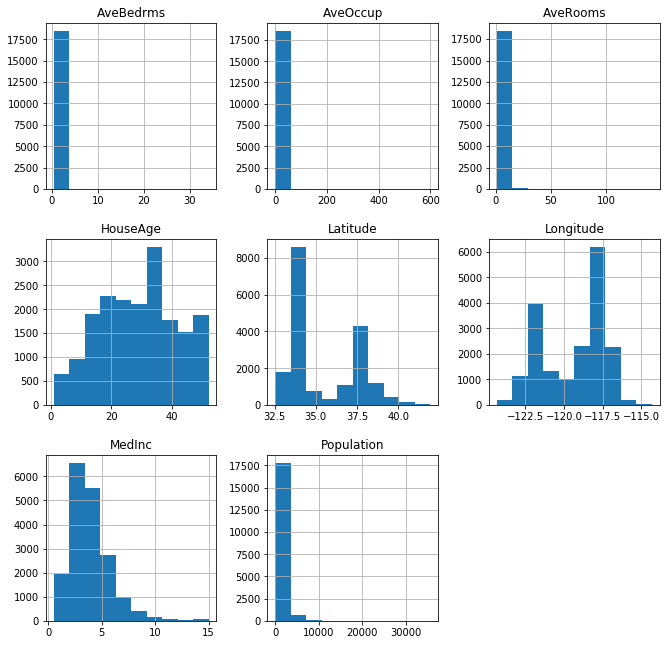

In [13]:
x_train_pd = pd.DataFrame(x_train, columns=housing.feature_names)

x_train_pd.hist(figsize=[11,11])
plt.show()

MedInc


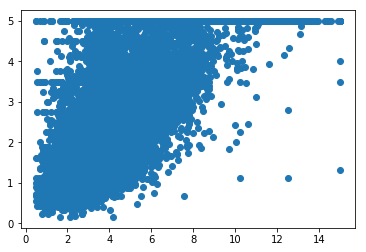

HouseAge


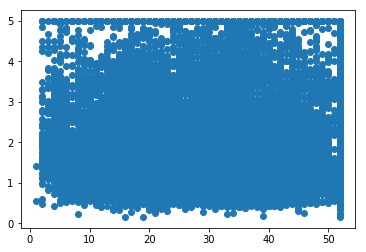

AveRooms


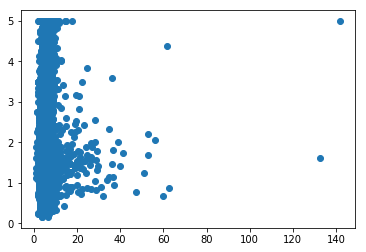

AveBedrms


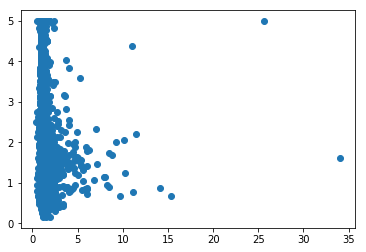

Population


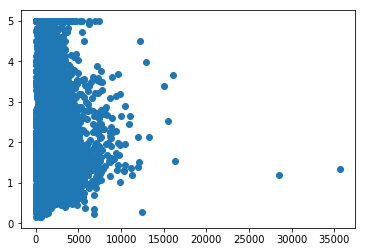

AveOccup


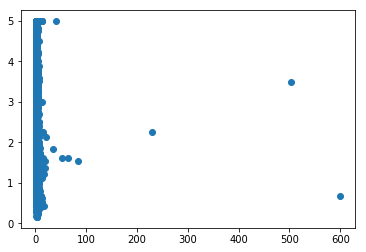

Latitude


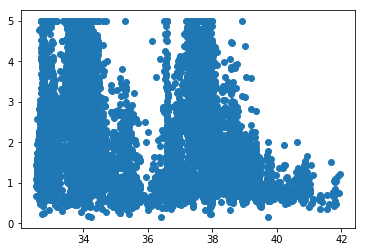

Longitude


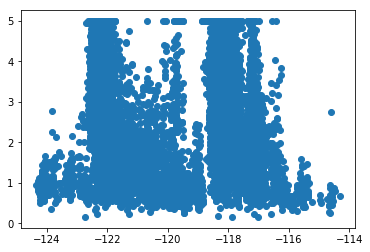

In [14]:
for col in x_train_pd.columns:
    print(col)
    plt.scatter(x_train_pd[col], y_train)
    plt.show()

In [15]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

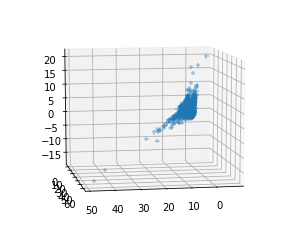

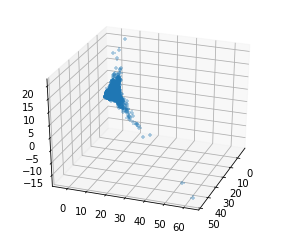

In [16]:
pca = PCA(n_components=3)
pca_res = pca.fit_transform(x_train_)

def plot_figs(fig_num, elev, azim):
    fig = plt.figure(fig_num, figsize=(4, 3))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=elev, azim=azim)

    ax.scatter(pca_res[:,0], pca_res[:,1], pca_res[:,2], marker='+', alpha=.4)



elev = 10
azim = 80
plot_figs(1, elev, azim)

elev = 30
azim = 20
plot_figs(2, elev, azim)

plt.show()
